In [2164]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import requests
from xml.etree import ElementTree as ET
from datetime import datetime
import warnings
warnings.filterwarnings("ignore")

# 1. Выбор дат для анализа


Импортируем дневные данные, начиная с 1 января 2025 года. Берем эту дату, так как она круглая и после экспирации предыдущего фьючерса. Чтобы сравнивать одни единицы измерения, домножим цену акции на 100 - именно столько акций в номинале 1 фьючерса

In [2165]:
from functions import parser_moex


df = parser_moex('2025-01-01', 'SBER', 'SRH5', timeframe=24)

candle = ['open', 'close', 'high', 'low']
for i in candle:
    df[f'{i}_SBER'] = df[f'{i}_SBER'] * 100


df.head()

,open_SBER,close_SBER,high_SBER,low_SBER,open_SRH5,close_SRH5,high_SRH5,low_SRH5
begin,,,,,,,,
2025-01-03 00:00:00,28000.0,27225.0,28041.0,27180.0,29088,28367,29175,28251
2025-01-06 00:00:00,27088.0,27437.0,27441.0,27007.0,28200,28327,28370,28061
2025-01-08 00:00:00,27307.0,27700.0,27787.0,27307.0,28280,28764,28890,28270
2025-01-09 00:00:00,27671.0,27180.0,27877.0,27073.0,28787,28214,28924,28073
2025-01-10 00:00:00,27231.0,27877.0,27953.0,27027.0,28213,28895,29077,28037


Теперь построим графики цен фьючерса и акции. 





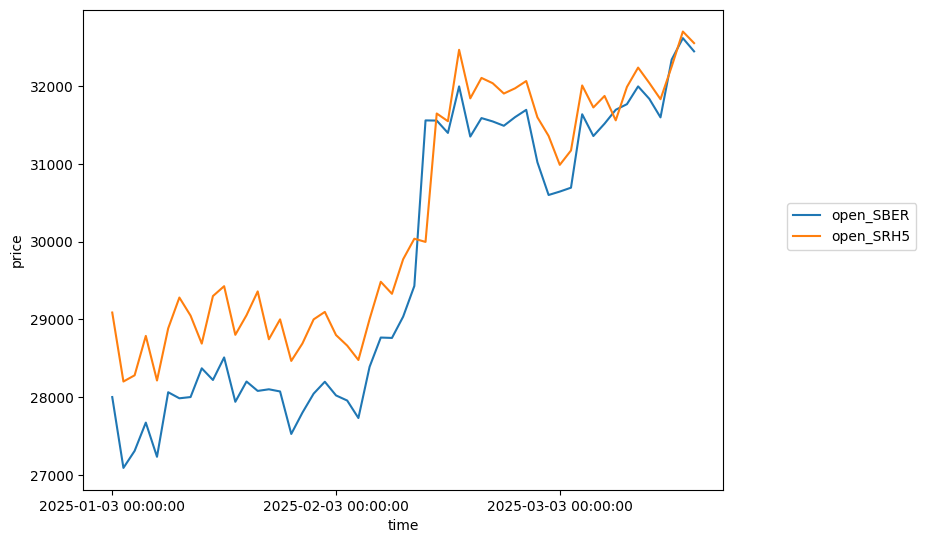

In [2166]:
m1 = 'open'
m2 = 'open'

fig = plt.figure()
axes = fig.add_axes([0,0,1,1])
axes.plot(df[f'{m1}_SBER'], label=f'{m1}_SBER')
axes.plot(df[f'{m2}_SRH5'], label=f'{m2}_SRH5')
axes.plot()
axes.set_xlabel('time')
axes.set_ylabel('price')
axes.set_xticks([0,20,40])


axes.legend(loc=(1.1,0.5))

Теперь посмотрим на базис - разница цены фьючерса и цены акции:

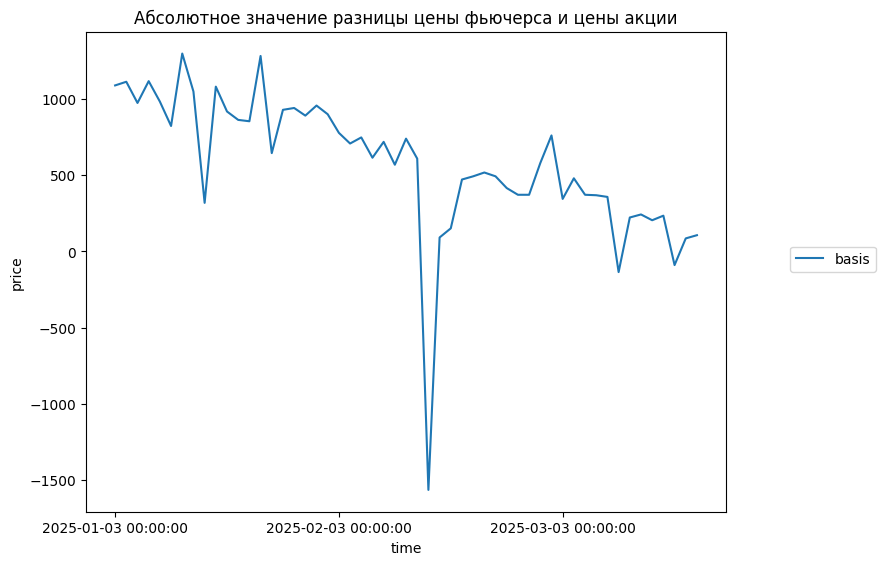

In [2167]:
m1 = 'open'
m2 = 'open'

fig = plt.figure()
axes = fig.add_axes([0,0,1,1])
axes.plot((df[f'{m2}_SRH5'] - df[f'{m1}_SBER']), label=f'basis')
axes.plot()
axes.set_xlabel('time')
axes.set_ylabel('price')
axes.set_title('Абсолютное значение разницы цены фьючерса и цены акции')

axes.set_xticks([0,20,40])


axes.legend(loc=(1.1,0.5))

Видим важные выводы:

1) базис действительно сходится к нулю при приближении к дате экспирации фьючерса

2) иногда значение базиса сильно отклоняется от "тренда" - это видно даже без построения тренда))

### Построение скользящей линейной регрессии

Добавим значение базиса в датафрейм для удобства:

Он называется open-open, это показывает, что мы вычитаем open_SBER из open_SRH5 

In [2168]:
df[f'basis_{m2}-{m1}'] = (df[f'{m2}_SRH5'] - df[f'{m1}_SBER'])
df = df.reset_index()


df.head()

,begin,open_SBER,close_SBER,high_SBER,low_SBER,open_SRH5,close_SRH5,high_SRH5,low_SRH5,basis_open-open
0,2025-01-03 00:00:00,28000.0,27225.0,28041.0,27180.0,29088,28367,29175,28251,1088.0
1,2025-01-06 00:00:00,27088.0,27437.0,27441.0,27007.0,28200,28327,28370,28061,1112.0
2,2025-01-08 00:00:00,27307.0,27700.0,27787.0,27307.0,28280,28764,28890,28270,973.0
3,2025-01-09 00:00:00,27671.0,27180.0,27877.0,27073.0,28787,28214,28924,28073,1116.0
4,2025-01-10 00:00:00,27231.0,27877.0,27953.0,27027.0,28213,28895,29077,28037,982.0


Создадим признаки для модели

Чтобы модель получилась, нам нужно переписать begin в даты. Как аргумент X мы будем использовать количество дней с 01.01, потому что модель не примет на вход даты. Также используем .values.reshape(-1, 1) чтобы преобразовать Х в датафрейм и он был не просто Series, опять же модель примет его только так.

In [2169]:

df['begin'] = pd.to_datetime(df['begin'])

df['days'] = (df['begin'] - df['begin'][0]).dt.days

df = df.drop(['close_SBER', 'high_SBER', 'low_SBER','close_SRH5', 'high_SRH5', 'low_SRH5'], axis=1)


Обучим модель:

обучаем ее на всех доступных данных, потому что это тренд

Очевидно, что в течение 6 марта мы не видим линейную регрессию с 1 января до 19 марта. Поэтому линейный тренд будет обновляться каждый день с учетом новой информации.

In [2170]:
y_hat_1 = []

for i in df.index[1:]:

    X = df['days'][0:i].values.reshape(-1, 1)
    y = df[f'basis_{m2}-{m1}'][0:i].values

    model = LinearRegression()
    model.fit(X, y)
    y_hat_1 += [model.predict(X)[-1]]

df['y_hat_1'] = 0

df.iloc[1:, df.columns.get_loc('y_hat_1')] = y_hat_1

df = df.drop(index=0)
df.head()

,begin,open_SBER,open_SRH5,basis_open-open,days,y_hat_1
1,2025-01-06,27088.0,28200,1112.0,3,1088.000000
2,2025-01-08,27307.0,28280,973.0,5,1112.000000
3,2025-01-09,27671.0,28787,1116.0,6,1009.710526
4,2025-01-10,27231.0,28213,982.0,7,1058.619048
5,2025-01-13,28062.0,28884,822.0,10,1020.818182


Посмотрим на тренд:

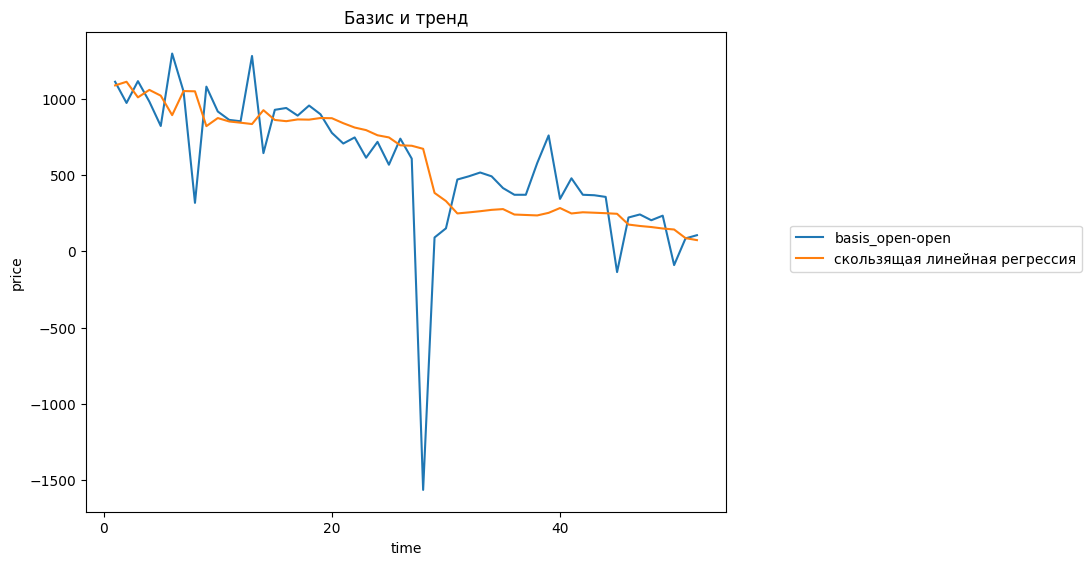

In [2171]:
y_h = df['y_hat_1']

fig = plt.figure()
axes = fig.add_axes([0,0,1,1])
axes.plot(df[f'basis_{m2}-{m1}'], label=f'basis_{m2}-{m1}')
axes.plot(y_h, label='скользящая линейная регрессия')
axes.set_xlabel('time')
axes.set_ylabel('price')
axes.set_title('Базис и тренд')

axes.set_xticks([0,20,40])


axes.legend(loc=(1.1,0.5))

### Построение теоретического базиса


что у нас есть:

In [2172]:

df.head()


,begin,open_SBER,open_SRH5,basis_open-open,days,y_hat_1
1,2025-01-06,27088.0,28200,1112.0,3,1088.000000
2,2025-01-08,27307.0,28280,973.0,5,1112.000000
3,2025-01-09,27671.0,28787,1116.0,6,1009.710526
4,2025-01-10,27231.0,28213,982.0,7,1058.619048
5,2025-01-13,28062.0,28884,822.0,10,1020.818182


Давайте добавим столбцы с теоретическими базисами. Есть две формулы рассчета теоретических цен: одна с экспонентой, другая без (описано в файле defenitions 1)

In [2173]:
r = 0.205 # ставка безриска (описано в defenitions 2)

#### С экспонентой

In [2174]:
df[f'theor_basis_{m2}-{m1}_ex'] = df[f'{m1}_SBER'] * (2.718 ** ((r * (datetime.strptime('2025-03-25', '%Y-%m-%d') - df['begin']).dt.days) / 365)) - df[f'{m1}_SBER']

df.head()

,begin,open_SBER,open_SRH5,basis_open-open,days,y_hat_1,theor_basis_open-open_ex
1,2025-01-06,27088.0,28200,1112.0,3,1088.000000,1212.925360
2,2025-01-08,27307.0,28280,973.0,5,1112.000000,1190.705787
3,2025-01-09,27671.0,28787,1116.0,6,1009.710526,1190.365115
4,2025-01-10,27231.0,28213,982.0,7,1058.619048,1155.491050
5,2025-01-13,28062.0,28884,822.0,10,1020.818182,1141.510531


#### Без эксопненты

In [2175]:
df[f'theor_basis_{m2}-{m1}'] = df[f'{m1}_SBER'] * (1 + (r * (((datetime.strptime('2025-03-25', '%Y-%m-%d') - df['begin']).dt.days) / 365))) - df[f'{m1}_SBER']

df.head()

,begin,open_SBER,open_SRH5,basis_open-open,days,y_hat_1,theor_basis_open-open_ex,theor_basis_open-open
1,2025-01-06,27088.0,28200,1112.0,3,1088.000000,1212.925360,1186.677041
2,2025-01-08,27307.0,28280,973.0,5,1112.000000,1190.705787,1165.597425
3,2025-01-09,27671.0,28787,1116.0,6,1009.710526,1190.365115,1165.593493
4,2025-01-10,27231.0,28213,982.0,7,1058.619048,1155.491050,1131.765123
5,2025-01-13,28062.0,28884,822.0,10,1020.818182,1141.510531,1119.020301


Нанесем фактический базис, его тренд, и два теоретических на один график

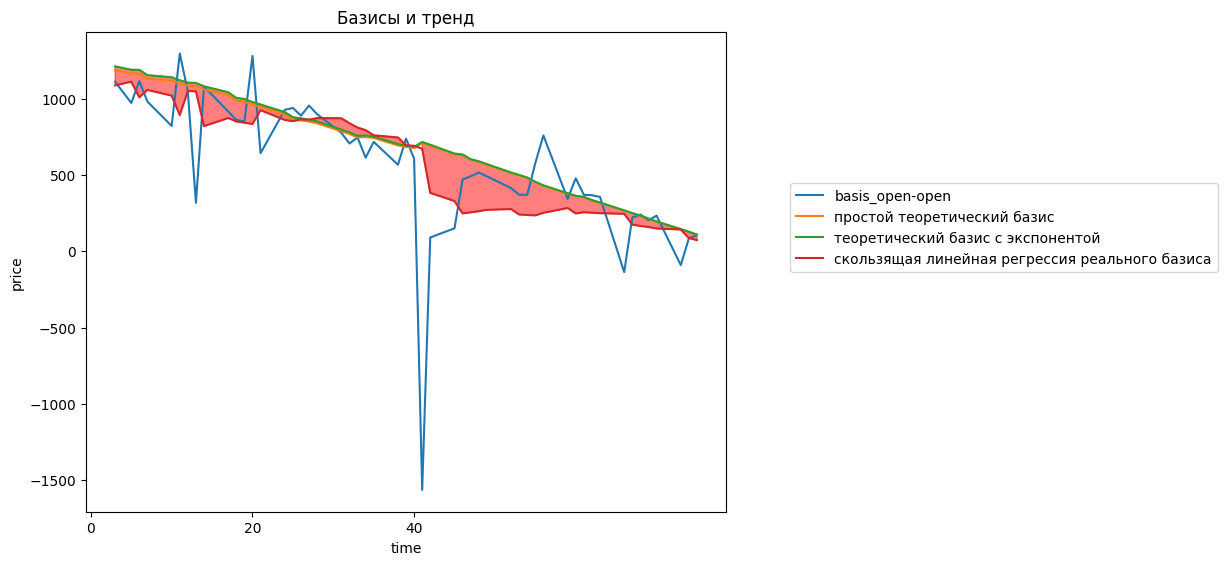

In [2176]:

fig = plt.figure()
x = df['days']
y = df[f'theor_basis_{m2}-{m1}_ex']
y_h = df['y_hat_1']

axes = fig.add_axes([0,0,1,1])
axes.plot(x, df[f'basis_{m2}-{m1}'], label=f'basis_{m2}-{m1}')
axes.plot(x, df[f'theor_basis_{m2}-{m1}'], label='простой теоретический базис')
axes.plot(x, df[f'theor_basis_{m2}-{m1}_ex'], label='теоретический базис с экспонентой')
axes.plot(x, y_h, label='скользящая линейная регрессия реального базиса')
axes.set_xlabel('time')
axes.set_ylabel('price')
axes.set_title('Базисы и тренд')

plt.fill_between(x, y_h, y, where=(y_h > y),color='red', alpha=0.5)
plt.fill_between(x, y, y_h, where=(y_h < y),color='red', alpha=0.5)



axes.set_xticks([0,20,40])


axes.legend(loc=(1.1,0.5))

Если базис находится между линией своего тренда и теоретической ценой - мы не будем заходить ни в какую сделку. Эта область раскрашена полупрозрачным красным.

Почему не будем? 

Считаем, что это просто часть риск-политики. Не хочется брать отклонение базиса только от теоретической цены или только от тренда - будем брать его отклонение от области между ними.


### Наконец-то выбираем даты

Удалим строки в датафрейме, где значение базиса в пределах границ. Оставим только строки, где базис либо ниже либо выше одновременно и теоретического базиса, и регрессии.

In [2177]:
df_one = df[((df[f'basis_{m2}-{m1}'] < df['y_hat_1']) & ((df[f'basis_{m2}-{m1}'] < df[f'theor_basis_{m2}-{m1}_ex']))) | ((df[f'basis_{m2}-{m1}'] > df['y_hat_1']) & ((df[f'basis_{m2}-{m1}'] > df[f'theor_basis_{m2}-{m1}_ex'])))]
df_one.head()

,begin,open_SBER,open_SRH5,basis_open-open,days,y_hat_1,theor_basis_open-open_ex,theor_basis_open-open
2,2025-01-08,27307.0,28280,973.0,5,1112.000000,1190.705787,1165.597425
4,2025-01-10,27231.0,28213,982.0,7,1058.619048,1155.491050,1131.765123
5,2025-01-13,28062.0,28884,822.0,10,1020.818182,1141.510531,1119.020301
6,2025-01-14,27984.0,29281,1297.0,11,893.133144,1121.987540,1100.192877
7,2025-01-15,28000.0,29048,1048.0,12,1051.055195,1106.278785,1085.095890


# 2. Процесс арбитража в течение дня

Итак. Каждый день с утречка мы считаем обновленную линейную регрессию и теоретическую цену по ценам открытия инструментов. Давайте сделаем список дат, в которые мы увидим потенциал для арбитража

In [2178]:
dates = df_one['begin']

date = '2025-02-03 00:00:00'

Если 

$$Базис \ < \ "границы"$$

нам выгодно 

$$long \ фьючерса \ +\ short \ акции$$

Наоборот - наоборот. Отсылаю к defenitions, где это описано подробнее. Для начала поймем что нам нужно делать - напишем штуку, которая нам высылает сигнал

In [2179]:
df = df_one[df_one['begin'] == date]



if df[f'basis_{m2}-{m1}'].values[0] < min(df['y_hat_1'].values[0], df[f'theor_basis_{m2}-{m1}_ex'].values[0]):
    signal = 'long_fut_short_stock'
elif df[f'basis_{m2}-{m1}'].values[0] > max(df['y_hat_1'].values[0], df[f'theor_basis_{m2}-{m1}_ex'].values[0]):
    signal = 'short_fut_long_stock'

signal


'long_fut_short_stock'

Допустим мы так и поступили ровно в 9:00 (с учетом минуты на просмотр сигнала), вкинув рыночную заявку на 1 фьючерс и 100 акций сбера. Объем маленький, поэтому считаем, что ее исполнят без проскальзывания и моментально.

In [2180]:
df = parser_moex(date, 'SBER', 'SRH5', timeframe=1)
candle = ['open', 'close', 'high', 'low']
for i in candle:
    df[f'{i}_SBER'] = df[f'{i}_SBER'] * 100
df.tail(1)

,open_SBER,close_SBER,high_SBER,low_SBER,open_SRH5,close_SRH5,high_SRH5,low_SRH5
begin,,,,,,,,
2025-02-03 15:18:00,27860.0,27861.0,27865.0,27860.0,28609,28611,28611,28609


Создадим аналог нашего счета, стартовать будем с нуля рублей.

In [2181]:
dep = 0

Таримся и закрываемся в конце дня (с учетом комисий):

In [2182]:
if signal == 'long_fut_short_stock':

    # открываем идею

    dep += df.head(2)['open_SBER'][1] # шортим акции, получаем деньги
    dep -= 0.0005 * dep # комиссия за шорт акций
    dep -= 0.0004 * df.head(2)['open_SRH5'][1]  # комиссия за лонг фьючерса

    # откупаем акции обратно, закрываем позицию во фьючерсе:

    dep -= df.tail(1)['open_SBER'][0] # откупаем акции обратно
    dep -= 0.0005 * df.tail(1)['open_SBER'][0] # комиссия за откуп акций
    dep += df.tail(1)['open_SRH5'][0] - df.head(2)['open_SRH5'][1] # получаем разницу цен фьючерса
    dep -= 0.0004 * df.tail(1)['open_SRH5'][0] # комиссия за закрытие фьючерса


    
    
dep 


-119.87740000000588

Вот они, наши кровно заработанные (прост в 5 утра пишу, реально заработал)

Давайте прогоним нашего "бота" по всем датам, и посмотрим, что мы заработали с 1 января. Оформим торговлю в цикл.

In [2183]:
result = []
good_days = [] ###

for dates in df_one['begin']:

    df = df_one[df_one['begin'] == dates]


    if df[f'basis_{m2}-{m1}'].values[0] < min(df['y_hat_1'].values[0], df[f'theor_basis_{m2}-{m1}_ex'].values[0]):
        signal = 'long_fut_short_stock'
    elif df[f'basis_{m2}-{m1}'].values[0] > max(df['y_hat_1'].values[0], df[f'theor_basis_{m2}-{m1}_ex'].values[0]):
        signal = 'short_fut_long_stock'
    
    df = parser_moex(dates, 'SBER', 'SRH5', timeframe=1)
    candle = ['open', 'close', 'high', 'low']
    for i in candle:
        df[f'{i}_SBER'] = df[f'{i}_SBER'] * 100

    dep = 0

    if signal == 'long_fut_short_stock':
    # открываем идею
        dep += df.head(2)['open_SBER'][1] # шортим акции, получаем деньги
        dep -= 0.0005 * dep # комиссия за шорт акций
        dep -= 0.0004 * df.head(2)['open_SRH5'][1]  # комиссия за лонг фьючерса
    # откупаем акции обратно, закрываем позицию во фьючерсе:
        dep -= df.tail(1)['open_SBER'][0] # откупаем акции обратно
        dep -= 0.0005 * df.tail(1)['open_SBER'][0] # комиссия за откуп акций
        dep += df.tail(1)['open_SRH5'][0] - df.head(2)['open_SRH5'][1] # получаем разницу цен фьючерса
        dep -= 0.0004 * df.tail(1)['open_SRH5'][0] # комиссия за закрытие фьючерса

    elif signal == 'short_fut_long_stock':
    # открываем идею
        dep -= df.head(2)['open_SBER'][1] # лонг акции, тратим деньги
        dep -= 0.0005 * dep # комиссия за лонг акций
        dep -= 0.0004 * df.head(2)['open_SRH5'][1]  # комиссия за шорт фьючерса
    # продаем акции обратно, закрываем позицию во фьючерсе:
        dep += df.tail(1)['open_SBER'][0] # продаем акции обратно
        dep -= 0.0005 * df.tail(1)['open_SBER'][0] # комиссия за продажу акций
        dep += df.head(2)['open_SRH5'][1] - df.tail(1)['open_SRH5'][0]  # получаем разницу цен фьючерса
        dep -= 0.0004 * df.tail(1)['open_SRH5'][0] # комиссия за закрытие фьючерса      

    if dep > 0:
        good_days += [dates] ###


    result += [dep]

    

In [2184]:
result

[-91.41560000000467,
 44.55250000000009,
 -26.4923000000002,
 -24.265099999997584,
 -144.00900000000144,
 -0.7584999999998914,
 -24.97640000000564,
 -44.27350000000185,
 61.11369999999825,
 6.037899999998638,
 -42.10449999999571,
 -43.11509999999971,
 -31.34780000000172,
 -119.87740000000588,
 -52.90770000000032,
 0.46370000000211675,
 -6.796500000003094,
 -48.34619999999755,
 -16.722199999998967,
 -78.94829999999922,
 -15.880500000000135,
 -57.94519999999818,
 -184.93179999999924,
 219.85160000000204,
 33.94040000000318,
 12.322299999998265,
 -141.52549999999636,
 46.36819999999959,
 -77.3634999999982,
 -20.947399999999746,
 -36.53880000000425,
 62.314799999999835,
 17.50049999999947,
 59.30650000000024,
 36.98170000000213]

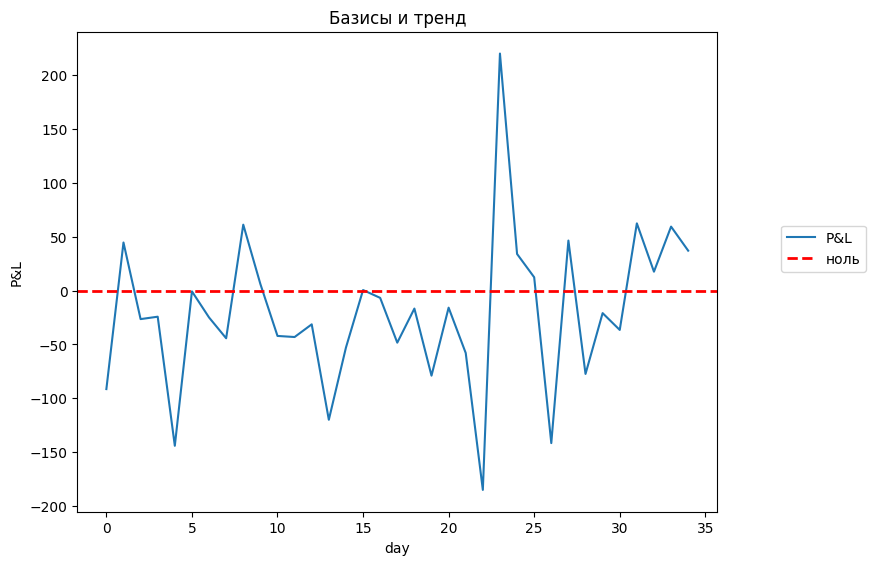

In [2185]:
fig = plt.figure()

axes = fig.add_axes([0,0,1,1])
axes.plot(result, label='P&L')

axes.set_xlabel('day')
axes.set_ylabel('P&L')
axes.set_title('Базисы и тренд')
plt.axhline(y=0, color='r', linestyle='--', linewidth=2, label="ноль")


axes.legend(loc=(1.1,0.5))

# 3. Откуда деньги? Пытаемся понять что сделали

Окей, иногда мы даже что-то зарабатываем! Давайте поймем когда и попытаемся выделить для себя эти дни, чтобы заходить в сделки только в них. На этом моменте я добавил в торговый цикл строки с ### в конце.
Мы получаем еще список дат, в которые заработали денег. Что было с базисом в эти моменты? Моя основная гипотеза сейчас - мы зарабатывали в волатильные дни.

In [2186]:
good_days

[Timestamp('2025-01-10 00:00:00'),
 Timestamp('2025-01-27 00:00:00'),
 Timestamp('2025-01-28 00:00:00'),
 Timestamp('2025-02-05 00:00:00'),
 Timestamp('2025-02-17 00:00:00'),
 Timestamp('2025-02-27 00:00:00'),
 Timestamp('2025-02-28 00:00:00'),
 Timestamp('2025-03-05 00:00:00'),
 Timestamp('2025-03-12 00:00:00'),
 Timestamp('2025-03-14 00:00:00'),
 Timestamp('2025-03-17 00:00:00'),
 Timestamp('2025-03-18 00:00:00')]

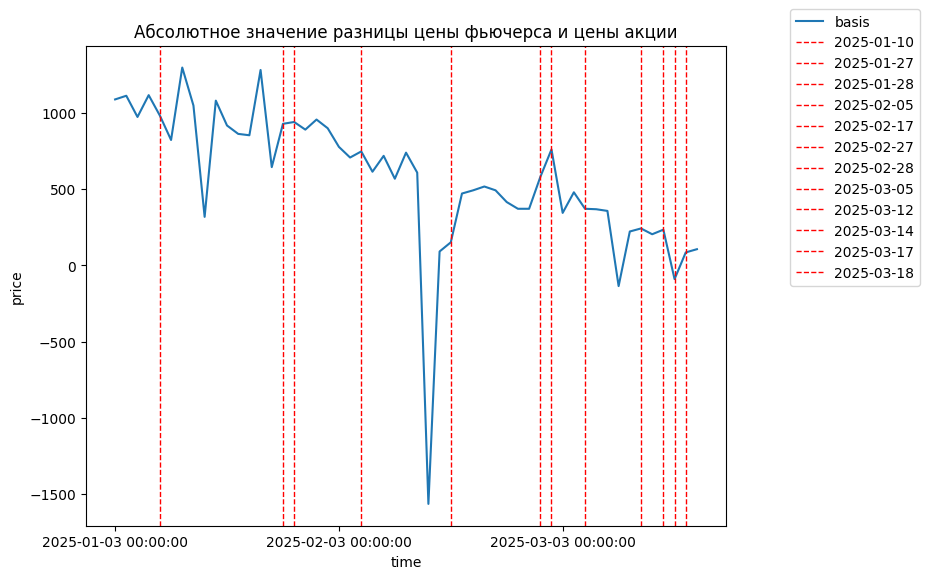

In [2187]:
df = parser_moex('2025-01-01', 'SBER', 'SRH5', timeframe=24)

candle = ['open', 'close', 'high', 'low']
for i in candle:
    df[f'{i}_SBER'] = df[f'{i}_SBER'] * 100

#df.index = pd.to_datetime(df.index)


m1 = 'open'
m2 = 'open'


fig = plt.figure()
axes = fig.add_axes([0,0,1,1])
axes.plot((df[f'{m2}_SRH5'] - df[f'{m1}_SBER']), label=f'basis')
for i in dates_list:
    plt.axvline(x=f'{i} 00:00:00', color='red', linestyle='--', linewidth=1, label=f"{i}")

axes.set_xlabel('time')
axes.set_ylabel('price')
axes.set_title('Абсолютное значение разницы цены фьючерса и цены акции')

axes.set_xticks([0,20,40])


axes.legend(loc=(1.1,0.5))


Пока ни о чем не говорит. Похоже на рандом. Посмотрим на график акции:

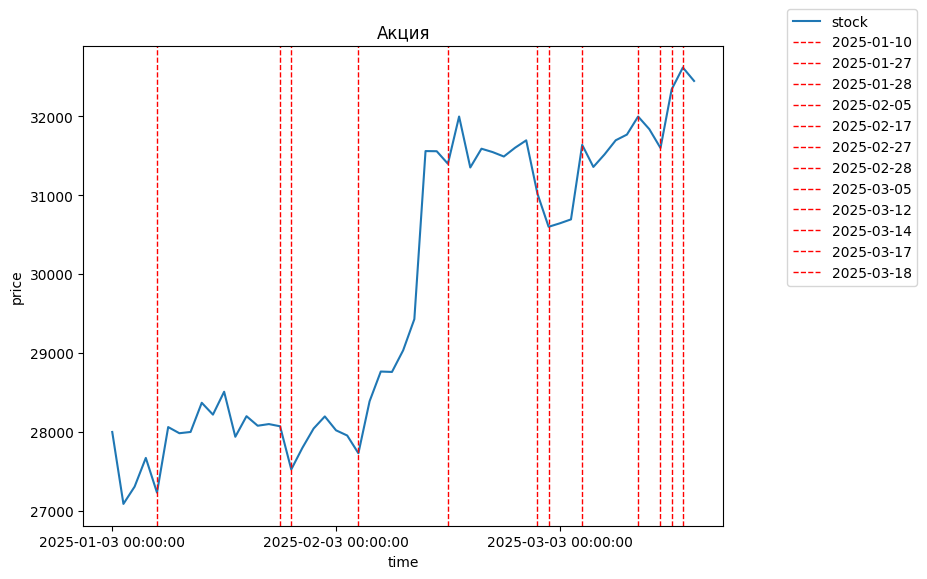

In [2188]:
df = parser_moex('2025-01-01', 'SBER', 'SRH5', timeframe=24)

candle = ['open', 'close', 'high', 'low']
for i in candle:
    df[f'{i}_SBER'] = df[f'{i}_SBER'] * 100


m1 = 'open'
m2 = 'open'


fig = plt.figure()
axes = fig.add_axes([0,0,1,1])
axes.plot(df[f'{m1}_SBER'], label=f'stock')
for i in dates_list:
    plt.axvline(x=f'{i} 00:00:00', color='red', linestyle='--', linewidth=1, label=f"{i}")

axes.set_xlabel('time')
axes.set_ylabel('price')
axes.set_title('Акция')

axes.set_xticks([0,20,40])


axes.legend(loc=(1.1,0.5))

Интересно получается. Видно, что иногда мы получали прибыль перед резкими движениями цен, а иногда просто так. Сейчас я считаю, что прибыль нам приходит рандомно.

Но у меня уже есть идеи по улучшению проекта: нужно покопаться в каждом дне, настроить механизм текй-профита и стоп-лосса, выбрать оптимальную долю портфеля для захода в сделки. 

Однако, это уже похоже на курсовую! 

# Результат - бысплатный бывает только сыр в мышеловке